# ASR-MT
## Lucida AI Evaluation

### Goal
Investigate the relationship between the errors of ASR (Automatic Speech Recognition) and the errors of MT (Machine Translation).

### Generate Quries from Original Data

100 sentences.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re, string, sys
from operator import itemgetter
import matplotlib.pyplot as plt
fig = plt.figure()
plt.rc("font", family="serif")
plt.rc("font", size=15)

In [2]:
# Return the Ensligh text corresponding to the specific sentence.
def get_English_text(id):
    links_with_id = links.loc[links['id'] == id]
    for translation_id in links_with_id['translation_id']:
        data_with_id = data.loc[data['id'] == translation_id]
        for index, row in data_with_id.iterrows():
            if row['lang'] == 'eng':
                return row['text']

# Generate 100 queires from the original data files
#'sentences.csv' and 'links.csv'.
# Format: 'Ensligh text','Chinese text'
# Save the queries to 'text/query.txt'.
# Data source: http://tatoeba.org/eng/downloads.
def generate_100_queires():
    data = pd.read_csv('sentences.csv', \
                       names = ["id", "lang", "text"], delimiter='\t')
    chinese_rows = data.loc[data['lang'] == 'cmn']
    links = pd.read_csv('links.csv', \
                        names = ["id", "translation_id"], delimiter='\t')
    num_queries = 100
    header = ['query', 'answer']
    query_data = pd.DataFrame(np.zeros((num_queries, len(header))), \
                              columns=header)
    # Randomly select 1000 rows, and pick 100 from them as queries.
    chinese_rows = chinese_rows.ix[np.random.choice(chinese_rows.index, 1000)]
    chinese_rows = chinese_rows.assign(english=np.zeros(chinese_rows.shape[0]))
    count = 0
    for index, row in chinese_rows.iterrows():
        if count >= num_queries:
            break
        english = get_English_text(row['id'])
        # Prefer long sentences without '.', ';', '?', or '!'.
        if english is not None and not '.' in english[0:-1] and \
        not ';' in english[0:-1] and not '?' in english[0:-1] and \
        not '!' in english[0:-1] and \
        len(english.split()) >= 10:
            query_data.ix[count, 'query'] = english
            query_data.ix[count, 'answer'] = row['text']
            count += 1
    if count < num_queries:
        raise RuntimeError('Too few data!')
    query_data.to_csv('text/query.txt')
    
# generate_100_queires()

In [3]:
# Generate the transcript with all the 100 English sentences in it
# stored in 'speech/transcript.txt'.
def generate_transcript():
    query_data = pd.read_csv('text/query.txt')
    file = open('speech/transcript.txt', 'w')
    for english in query_data['english']:
        file.write(english + '\n')
    print('Use the transcript to generate audio files!')
        
# generate_transcript()

### Convert Traditional Chinese to Simplified Chinese

[This tool](https://www.branah.com/traditional-to-simplified) could help.

### Generate Raw Data by Sending Queries to the Pipeline

### Generate DataFrame from ASR Results

In [4]:
# Return a DataFrame from the file with the following format:
# <audio_path>,<transcript>
# in which the audio path is of the following format:
# "path/to/file/<query_id>_<text>.wav"
# An example file:
# ../asr_mt/speech/0_Helloworld.wav,"hello world."
# Its first line must have be the header!
# The DataFrame has only one column: transcript
# with the specified header
# and sorted by the query id.
def get_df_from_asr_result(file_path, header):
    file = open(file_path, 'r')
    lines = file.readlines()
    lines.pop(0) # pop the header
    file.close()
    proc_lines = []
    for line in lines:
        line = line.lstrip().rstrip('\n')
        # The first occurrence of a number is assumed to be the query id.
        id = int(re.search(r'\d+', line).group())
        transcript = line.split(',')[1]
        if transcript.startswith('"') and transcript.endswith('"'):
            transcript = transcript[1:-1]
        proc_lines.append((id, transcript))
    proc_lines.sort(key=itemgetter(0)) # sort data by ID
    df = pd.DataFrame([row[1] for row in proc_lines], columns=[header])
    return df

# data = pd.read_csv('text/query.txt', index_col=0)

# asr_labels = ['fisher', 'librispeech', 'tedlium']

# for asr_label in asr_labels:
#     data = data.join \
#     (get_df_from_asr_result('asr_result_{}.txt'.format(asr_label), \
#                             'transcript_{}'.format(asr_label)))

In [5]:
oldstdout = sys.stdout
sys.stdout = open('log.txt', 'w')
# Return a DataFrame from Google MT result data
# and evaluate the result using the BLEU metric.
# In order to match the query in the Google MT result data
# to the query in `data`,
# the column name to match should be specified.
def get_df_from_google_result(mt_label, data, match_col):
    sys.path.append('../../mt')
    from bleu import Evaluator
    e = Evaluator()
    google_data = pd.read_csv('mt_result_{}.txt'.format(mt_label))
    results = []
    for j, asr_output in enumerate(data[match_col]):
        print(mt_label, asr_output)
        print(data['query'].ix[j])
        match_row = -1
        if asr_output != '':
            for i, mt_input in enumerate(google_data['text']):
                # Some weird problem leads to some '"' left in the sentence.
                mt_input = mt_input.replace('"', '')
                if mt_input == asr_output.replace('"', ''):
                    match_row = i
                    break
            if match_row == -1:
                raise RuntimeError('Cannot find the query ' + asr_output)
            result = google_data['translation'].ix[match_row]
        else:
            result = None # ASR did not return any result, so MT must be wrong!
        score = e.evaluate(result, data['answer'].ix[j])
        results.append((j, result, score))
        sys.stdout.flush()
    assert(len(results) == data.shape[0])
    results.sort(key=itemgetter(0)) # sort data by row index
    df = pd.DataFrame({'answer_{}'.format(mt_label): [row[1] for row in results], \
                      'score_{}'.format(mt_label): [row[2] for row in results]})
    return df
    
# mt_labels = [('fisher_google', 'transcript_fisher'), \
#              ('librispeech_google', 'transcript_librispeech'), \
#              ('tedlium_google', 'transcript_tedlium'), \
#              ('regular_google', 'query')]
# 
# for mt_label, match_col in mt_labels:
#     data = data.join \
#     (get_df_from_google_result(mt_label, data, match_col), lsuffix='')
# data = data[['query', 'chinese', 
#              'answer_regular_google', 'score_regular_google', \
#              'transcript_fisher', 'answer_fisher_google', \
#              'score_fisher_google', \
#              'transcript_librispeech', 'answer_librispeech_google', \
#              'score_librispeech_google', \
#              'transcript_tedlium', 'answer_tedlium_google', \
#              'score_tedlium_google']]
# data.to_csv('data.txt') # save to disk
sys.stdout = oldstdout

### Observation

In [6]:
from IPython.display import display
pd.set_option('display.max_colwidth', -1) # display full text
data = pd.read_csv('data.txt', index_col=0)
data[:]

,query,chinese,answer_regular_google,score_regular_google,transcript_fisher,answer_fisher_google,score_fisher_google,transcript_librispeech,answer_librispeech_google,score_librispeech_google,transcript_tedlium,answer_tedlium_google,score_tedlium_google
0,"Life being very short, we ought not to waste time.",人生十分短暂，我们不应该浪费时间。,人生十分短促，我们不应该浪费时间。,0.660633,i've been very shortly out not to waste time.,我已经很短了不是浪费时间。,0.451801,I'VE BEEN VERY SHORTLY OUGHT NOT TO WASTE TIME.,我已经很短不应该浪费时间。,0.305098,i've been very short we are not to waste time.,我已经很短，我们不能浪费时间。,0.379918
1,It's a pity that you can't buy miracles like you would buy potatoes.,可惜我们不能像买土豆一样买奇迹。,这是，你可以不买奇迹就像你会买土豆可惜。,0.508133,it's it's pretty that you can't buy miracles like you would buy potatoes.,这是它很，你可以不买奇迹就像你买土豆。,0.491450,IT'S A PITY THAT YOU CAN'T BY MIRACLES LIKE YOU WOULD BUY POTATOES.,可惜的是，你可以不被奇迹就像你买土豆。,0.426108,it's a pity that you can buy americans like you would buy potatoes.,那就是你可以买到美国人喜欢你会买土豆可惜。,0.379918
2,My father has been living in Nagoya for 30 years.,我父亲住在名古屋有30年了。,我的父亲一直住在名古屋的30年。,0.373421,my son has been living in the glass source radio years.,我的儿子一直住在玻璃源无线电年。,0.436684,MY FATHER HAS BEEN LIVING IN NAGOYA FOR FRIO YEARS.,我的父亲一直住在名古屋FRIO年。,0.289178,my father has been living in nagoya force rio years.,我的父亲一直住在名古屋力拓年。,0.331808
3,"The average man fails not because he lacks ability, but because he lacks ability to concentrate.",通常人们失败并非能力不足，而是不够专注。,一般人失败，不是因为他缺乏能力，而是因为他缺乏集中精力的能力。,0.204659,the average man sells not because she lets ability but because he lets ability to concentrate.,一般人不卖，因为她让的能力，但因为他让集中精力的能力。,0.668740,THAT VARIES MAN FAILS NOT BECAUSE HE LACKS ABILITY BUT BECAUSE HE LACKS ABILITY TO CONCENTRATE.,它改变人类不能倒不是因为他没有能力，而是因为他缺乏能力集中。,0.196922,that average man fails not because he laughs ability but because he laughs ability to concentrate.,那一般人失败，不是因为他的能力笑，而是因为他笑道集中精力的能力。,0.184264
4,Would the girls please bring the donation boxes up to the stage?,我们请女孩带着募捐箱来到舞台。,请问姑娘请带上募捐箱到舞台？,0.816497,but the girls please bring the donations houses up to the stage.,但女生请携带捐赠的房子到了舞台。,0.406380,BUT THE GIRLS PLEASE BRING THE DONATION BUFF AS UP TO THE STAGE.,但是女孩请随时到舞台带来捐赠BUFF。,0.744782,but the girls please bring the donation of says up to the stage.,但女生请携带捐赠表示了舞台。,0.451801
5,She told me that she would go to Paris in August.,她跟我说八月份她会去巴黎。,她告诉我，她会去巴黎在8月。,0.269855,she told me that she would go to paris in august.,她告诉我，她会去巴黎在8月。,0.269855,SHE TOLD ME THAT SHE WOULD GO TO PARIS IN AUGUST.,她告诉我，她会去巴黎在8月。,0.269855,she told me that she would go to paris and honest.,她告诉我，她会去巴黎和诚实。,0.269855
6,Since then he had put his whole soul into his work.,从那时起，他就全心全意地投入到他的工作。,从那时起，他已经把他的整个灵魂到他的工作。,0.412118,since then he had put his whole cylinder has worked.,从那时起，他已经把他的整个气缸工作过。,0.247124,SINCE THEN HE HAD PUT HIS WHOLE SOUL INTO HIS WORK.,从那时起，他已经把他的整个灵魂进入他的作品。,0.203334,since then he had put his halsall into his work.,从那时起，他已经把他的halsall到他的工作。,0.300249
7,A man came over and asked if I was OK.,一个男人过来问我怎么了。,一名男子走过来，问我是不是确定。,0.400160,and then came over and asked if i was okay.,然后走了过来，问我是不是没事。,0.417226,A MAN CAME OVER AND ASKED IF I WAS OKAY.,一个人治理走过来，问我是否还可以。,0.441163,a man came over and asked if i was ok.,一名男子走了过来，问我怎么样了。,0.417226
8,I didn't get to spend a lot of time with you on this visit.,你这次来，我都没跟你在一起待多久。,我没有花很多时间与你的这次访问。,0.643187,i didn't get to spend a lot of time with you on this visit.,我没有得到花了很多时间与你的这次访问。,0.689639,I DIDN'T GET TO SPEND A LOT OF TIME WITH YOU ON THIS VISIT.,我没有花时间了很多与你这次访问。,0.332447,i didn't get to spend a lot of time with you on this visit.,我没有得到花了很多时间与你的这次访问。,0.689639
9,Do you know the concert schedule of London Symphony Orchestra?,你知道伦敦交响乐团的演奏会行程吗？,你知道伦敦交响乐团的音乐会时间表？,0.477503,do you know the concerts schedule of london cincinnati orchestra.,你知道伦敦辛辛那提交响乐团的音乐会日程。,0.415351,DO YOU KNOW THE CONCERT SCHEDULE OF LONDON SYMPHONY ORCHESTRA.,你知道伦敦交响乐团的音乐会时间表。,0.456227,i am now the concert schedule of london symphony orchestra.,我现在是伦敦交响乐团的音乐会日程。,0.330316


### Collect Statistics and Plot

In [7]:
sys.path.append('../../asr')
from wer import error_rate

# Analyze the data for the specified ASR and return the statistics.
def analyze(data, asr_name, mt_name):
    size = data.shape[0]
    asr_errors = np.zeros(size)
    for j, transcript in enumerate(data['_'.join(['transcript', asr_name])]):
        asr_errors[j] = error_rate(data['query'][j], transcript)
    relative_scores = np.zeros(size)
    with_asr_scores = data['_'.join(['score', asr_name, mt_name])]
    regular_scores = data['_'.join(['score', 'regular', mt_name])]
    for j, answer in enumerate(data['_'.join(['answer', asr_name, mt_name])]):
        with_asr_score = with_asr_scores[j]
        regular_score = regular_scores[j]
        if with_asr_score == regular_score:
            relative_scores[j] = 0
        elif with_asr_score > regular_score:
            relative_scores[j] = -1
        else:
            relative_scores[j] = 1
    avg_mt_accuracy = np.mean(with_asr_scores)
    avg_regular_mt_accuracy = np.mean(regular_scores)
    print('avg_asr_error:', asr_errors.mean(), \
          'avg_mt_accuracy:', avg_mt_accuracy, \
          'avg_regular_mt_accuracy', avg_regular_mt_accuracy)
    return {'asr_name': asr_name, 'mt_name': mt_name, \
            'asr_errors': asr_errors, \
            'avg_asr_error': asr_errors.mean(), \
            'relative_scores': relative_scores, \
            'avg_mt_accuracy': avg_mt_accuracy, \
            'avg_regular_mt_accuracy': avg_regular_mt_accuracy}

# Plot the relative scores vs error rates for a particular ASR+MT combination.
def plot_score_vs_error(color, asr_name, mt_name, asr_errors, relative_scores, **extras):
    plt.xlabel('ASR Error Rate')
    plt.ylabel('MT Relative Score')
    plt.title(' '.join([asr_name, mt_name]))
    plt.scatter(asr_errors, relative_scores, label=asr_name, color=color)

avg_asr_error: 0.709634947876 avg_mt_accuracy: 0.41885960247208964 avg_regular_mt_accuracy 0.4198994234372686


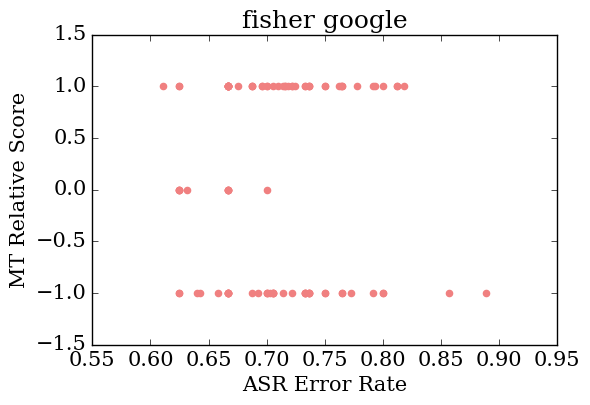

In [8]:
google_stats_list = []
google_stats_list.append(analyze(data, 'fisher', 'google'))
plot_score_vs_error('lightcoral', **google_stats_list[-1])

avg_asr_error: 0.673572363734 avg_mt_accuracy: 0.3800859916287618 avg_regular_mt_accuracy 0.4198994234372686


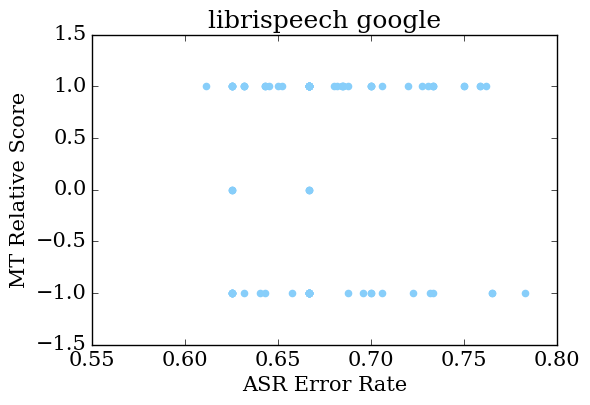

In [9]:
google_stats_list.append(analyze(data, 'librispeech', 'google'))
plot_score_vs_error('lightskyblue', **google_stats_list[-1])

avg_asr_error: 0.693509847775 avg_mt_accuracy: 0.38055289330061115 avg_regular_mt_accuracy 0.4198994234372686


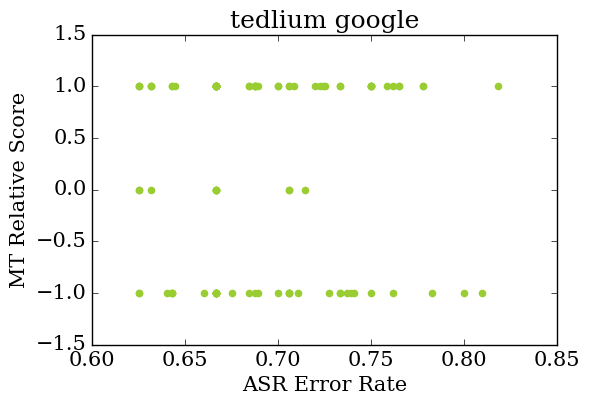

In [10]:
google_stats_list.append(analyze(data, 'tedlium', 'google'))
plot_score_vs_error('yellowgreen', **google_stats_list[-1])

In [11]:
# Return the data from the list of MT statistics (one for each ASR model).
def gather_data_for_mt_vs_asr(stats_list):
    asr_name_list = [stats['asr_name'] for stats in stats_list]
    avg_asr_accuracy_list = [1 - stats['avg_asr_error'] for stats in stats_list]
    avg_mt_accuracy_list = [stats['avg_mt_accuracy'] for stats in stats_list]
    avg_regular_mt_accuracy_list = \
    [stats['avg_regular_mt_accuracy'] for stats in stats_list]
    avg_mt_accuracy_drop_list = \
    [stats['avg_mt_accuracy'] - avg_regular_mt_accuracy_list[i] \
     for i, stats in enumerate(stats_list)]
    avg_mt_accuracy_drop_percentage_list = \
    [ (avg_mt_accuracy_drop / avg_regular_mt_accuracy_list[i]) * 100 \
     for i, avg_mt_accuracy_drop in enumerate(avg_mt_accuracy_drop_list)]
    return asr_name_list, avg_asr_accuracy_list, avg_mt_accuracy_list, \
avg_regular_mt_accuracy_list, avg_mt_accuracy_drop_list, \
avg_mt_accuracy_drop_percentage_list

# Plot the performance of a particular MT under the influence of different ASR models.
def plot_mt_vs_asr(stats_list, mt_name):    
    plt.xlabel('Average ASR Accuracy')
    plt.ylabel('Average MT Accuracy')
    plt.title('Performace of {}\n under the influence of ASR'.format(mt_name))
    # Gather data.
    asr_name_list, avg_asr_accuracy_list, avg_mt_accuracy_list, \
    avg_regular_mt_accuracy_list, \
    avg_mt_accuracy_drop_list, avg_mt_accuracy_drop_percentage_list = \
    gather_data_for_mt_vs_asr(stats_list)
    # Plot.
    plt.scatter(avg_asr_accuracy_list, avg_mt_accuracy_list, color='orange')
    for i, avg_asr_accuracy in enumerate(avg_asr_accuracy_list):
        txt = '{} ({:.2f},{:.3f})\n$\Delta$Accuracy={:.2f}({:.2f}%)'.format \
        (asr_name_list[i], avg_asr_accuracy, avg_mt_accuracy_list[i], \
         avg_mt_accuracy_drop_list[i], \
         avg_mt_accuracy_drop_percentage_list[i])
        plt.annotate(txt, (avg_asr_accuracy, avg_mt_accuracy_list[i]), \
                    fontsize=10)

# Plot the performance of a different MTs under the influence of different ASR models.
def plot_mts_vs_asr(list_of_stats_list, list_of_mt_name, list_of_colors):
    assert(len(list_of_stats_list) == len(list_of_mt_name))
    assert(len(list_of_mt_name) == len(list_of_colors))
    plt.xlabel('Average ASR Accuracy')
    plt.ylabel('Average MT Accuracy')
    plt.title('Performace of {}\nunder the influence of ASR'. \
              format(', '.join(list_of_mt_name)))
    for i, stats_list in enumerate(list_of_stats_list):
        mt_name = list_of_mt_name[i]
        # Gather data.
        asr_name_list, avg_asr_accuracy_list, avg_mt_accuracy_list, \
        avg_regular_mt_accuracy_list, \
        avg_mt_accuracy_drop_list, avg_mt_accuracy_drop_percentage_list = \
        gather_data_for_mt_vs_asr(stats_list)
        # Plot.
        plt.scatter(avg_asr_accuracy_list, avg_mt_accuracy_list, \
                    label=mt_name, color=list_of_colors[i])
        plt.legend(loc=3)
        for i, avg_asr_accuracy in enumerate(avg_asr_accuracy_list):
            txt = '{} ($\Delta$Accuracy {:.2f}%)'.format \
            (asr_name_list[i], avg_mt_accuracy_drop_percentage_list[i])
            plt.annotate(txt, (avg_asr_accuracy, avg_mt_accuracy_list[i]), \
                         fontsize=10)

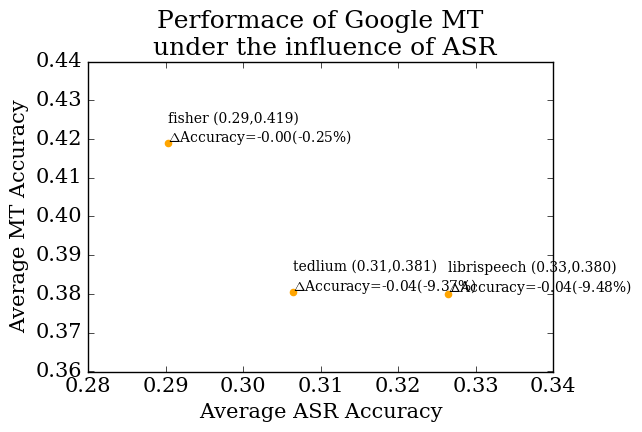

In [12]:
plot_mt_vs_asr(google_stats_list, 'Google MT')